# Analysis of Game Data

In [543]:
import numpy as np
#import scipy as sp
from numpy import asarray as narr
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import specgram
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import yaml

In [544]:
result_dr = '/home/saber/hhgame/saved_data/single-pt4/18-11-16-11-53'
exp_dr = '/home/saber/hhgame'

In [545]:
level=3

In [546]:
def read_data():
# implement when necessary
    pass

In [547]:
resdf = pd.read_csv(result_dr+'/results_lv'+str(level)+'.csv', quoting=3, escapechar=' ')
# Split the dataframe
newrep_i = resdf.Timestamp[resdf.Timestamp==0].index.values
resdf1 = resdf[:newrep_i[0]]
resdf2 = resdf[newrep_i[0]+1:-1]

In [548]:
# Some constants

sr_orig = 30 #30 frames/second
sp_orig = 1000/sr_orig #33 ms between each two samples

Text(0.5,1,'Y direction')

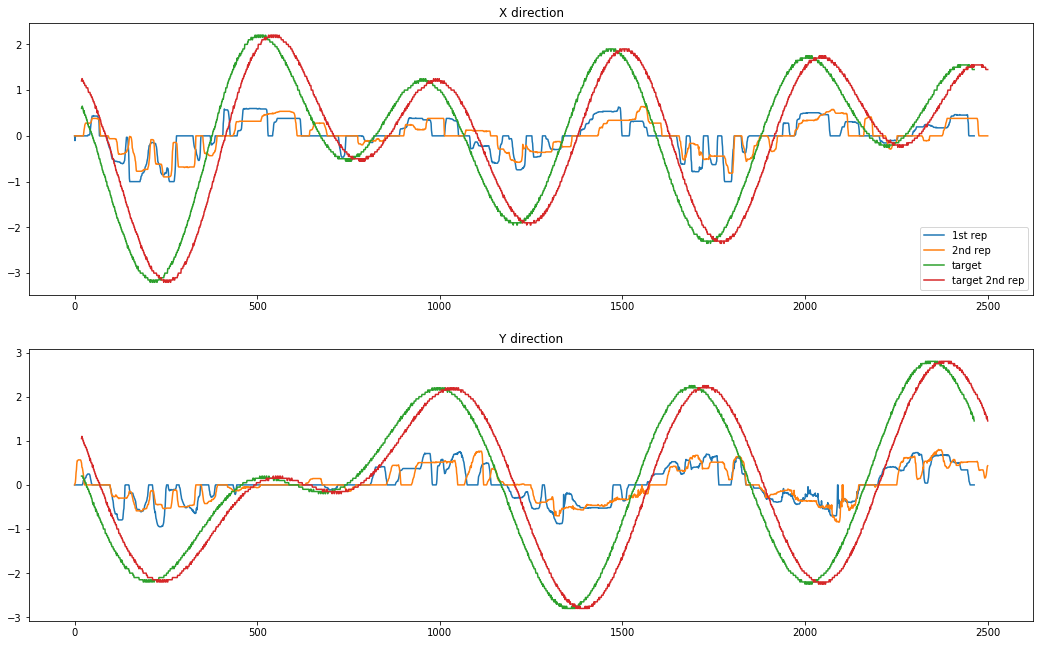

In [549]:
# Compare the repetitions
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(18,11))
ax1.plot(resdf1.Joy1PosX.values, label='1st rep')
ax1.plot(resdf2.Joy1PosX.values, label='2nd rep')
tpostemp1 = resdf1.KernelEndX.diff().fillna(0).rolling(window=20).mean()
ax1.plot(tpostemp1.values, label='target')

tpostemp2 = resdf2.KernelEndX.diff().fillna(0).rolling(window=20).mean()
ax1.plot(tpostemp2.values, label='target 2nd rep')

ax1.set_title('X direction')
ax1.legend()

ax2.plot(resdf1.Joy1PosY.values)
ax2.plot(resdf2.Joy1PosY.values)
tpostemp1 = resdf1.KernelEndY.diff().fillna(0).rolling(window=20).mean()
ax2.plot(tpostemp1.values, label='target')

tpostemp2 = resdf2.KernelEndY.diff().fillna(0).rolling(window=20).mean()
ax2.plot(tpostemp2.values, label='target 2nd rep')
ax2.set_title('Y direction')

There seems to be 36 frames of delay in the beginning of the second repetition. This is probably because we finish the repetition as soon as TargetKernel[1] reaches the end of the trajectory.

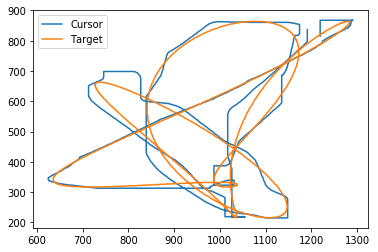

In [550]:
# Plot the trajectories
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(1000*p1traj[:,0], 1000*p1traj[:,1], label='P1')
#ax.plot(1000*p2traj[:,0], 1000*p2traj[:,1], label='P2')
ax.plot(resdf2.CursorPosX, resdf2.CursorPosY, label='Cursor')
ax.plot(resdf2.KernelEndX, resdf2.KernelEndY, label='Target')
ax.legend()

In the above case (which is limited), the result is as expected: It seems like the direction of the error is a good predictor and the direction of kernel is not. It may still have some small influence.

# Fitting linear models

Fitting the data using Scikit learn. 

We try linear regression with different feature sets.

In [551]:
# Preprocessing: preparing features
def preproc(Data, scale_f, scale_b, sp=None):
    # Includes resampling of the whole data. And then normalizing cursor pos, target pos.
    # Data is a dataframe
    # sp is the new sampling period (in ms) for downsampling.
    # Note that sp should be >= 34
    
    Data = Data.set_index('Timestamp')
    ind_temp = pd.to_datetime(Data.index, unit='ms')
    Data.index = ind_temp
    
    if sp is not None: #This is a dumb, but short and flexible implementation of resampling.
        spstr = str(sp)+'ms'
        Data = Data.asfreq('1ms') # !!Warning: This line increases the size of Data by 34 times.
        Data=Data.resample(spstr).mean()

    # Converting the data from the game coordinates to analysis coordinates.
    # Since we don't need our data to be distributed exactly in [0,1], 
    # we'll use one scaling factor and one bias for all variables for simplicity.
    t = pd.to_numeric(Data.index)/1000000
    t = t-min(t)

    tpos = narr([Data.KernelEndX.values, Data.KernelEndY.values], dtype=float).T
    tposd = narr([Data.KernelEndX.diff().fillna(0).rolling(window=20).mean(), 
                  Data.KernelEndY.diff().fillna(0).rolling(window=20).mean()]).T
    tpos[:, 0] = (tpos[:, 0]-scale_b)/scale_f 
    tpos[:, 1] = (tpos[:, 1]-scale_b)/scale_f # Center around 0, but scale by the same factor
    
    tposd = tposd/10
    
    cpos = narr([Data.CursorPosX.values, Data.CursorPosY.values], dtype=float).T
    cpos[:, 0] = (cpos[:, 0]-scale_b)/scale_f 
    cpos[:, 1] = (cpos[:, 1]-scale_b)/scale_f
    
    exsig = narr([Data.ExSigX.values, Data.ExSigY.values], dtype=float).T

    poserr = tpos - cpos

    outputI = narr([Data.Joy1PosX.values, Data.Joy1PosY.values]).T
    output = narr([Data.Joy1PosX.diff().fillna(0), Data.Joy1PosY.diff().fillna(0)]).T
    

    return t, tpos, tposd, cpos, exsig, poserr, output, outputI

In [552]:
Fs = sr_orig

# Selecting a batch
train_batch_s = Fs*0
train_batch_e = -Fs*1
data = resdf2[train_batch_s:train_batch_e]

dsr=6
sp = np.ceil(sp_orig*dsr) # Sampling period(sp).
# Note that downsampling rate(dsr) = sp_new/sp_old = sr_old/sr_new
#sp = None
winlen = 5

# Preprocessing parameters
scale_f = np.std(data.KernelEndX.values) # scale by the standard deviation of target
scale_b = np.mean(data.KernelEndX.values) # Shift by the mean of the target position

# Downsampling, in order to reduce redundancy (making prediction harder)
t, tpos, tposd, cpos, exsig, poserr, output, outputI = preproc(data, scale_f, scale_b, sp)

In [553]:
#joyouts = resdf.loc[:,('Joy1PosX','Joy1PosY')]
#joyouts.plot.hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4694aeb940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f46949ddbe0>]], dtype=object)

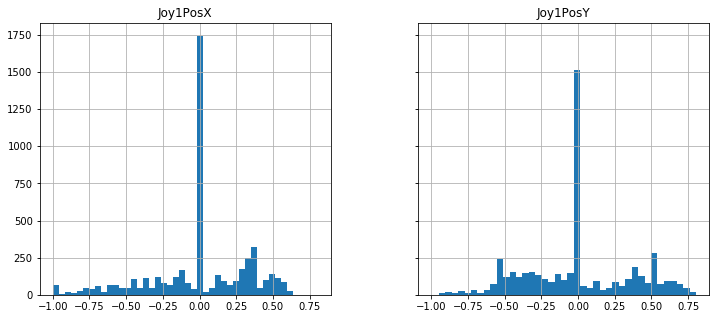

In [554]:
resdf.hist(column=['Joy1PosX','Joy1PosY'], bins=40, sharex=True, sharey=True, figsize=(12, 5))
#fig, ax = plt.subplots(2,1)
#resdf.Joy1PosX.hist(ax=ax[0], bins=50)
#resdf.Joy1PosY.hist(ax=ax[1], bins=50)
#plt.savefig("test1111.png", dpi = 300)

In [555]:
def vec2window(v, wlen, cut_pad=False):
    # Creates an array from a vector. Uses the shifted version
    # of the vector as new columns. 
    # example: input: [1, 2, 3, 4], wlen=3
    # output:
    # [1 0 0
    #  2 1 0
    #  3 2 1
    #  4 3 2]
    # If v is a time series, each row will include a window of 
    # the previous values.The first element is the most recent sample.
    # wlen: window length
    # If cut_pad is true, the padded part with made-up data (zeros) is removed.
    
    arr = np.zeros((v.shape[0], wlen))
    arr[:,0] = v
    for i in range(1, wlen):
        arr[:,i] = np.pad(v, (i, 0), 'edge')[:-i] # Adds i edge values to the beginning 
                                    # and 0 edge values to the end of the selected column
    if cut_pad is True:
        arr = arr[wlen:, :]
    return arr

## Model 2
#### features: Positional error (tpos - cpos, i.e. target - cursor), previous user outputs (u)

In [556]:
# 2nd model
# features: (1) x = [e, u] for the past 15 frames
ex = vec2window(poserr[:,0], winlen)
ey = vec2window(poserr[:,1], winlen)

# thresh = 3*np.std(poserr[:,0]) #@@@@@@@@
# nex = poserr[:,0]
# nex[np.abs(nex)<thresh]=0
# nex = nex*np.random.rand(poserr.shape[0])

# ney = poserr[:,1]
# ney[np.abs(ney)<thresh]=0
# ney = ney*np.random.rand(poserr.shape[0])

tempvar = np.pad(outputI, ((1,0),(0, 0)), 'constant')[:-1] # To avoid using the current value of output!
ux = vec2window(tempvar[:, 0], winlen)
uy = vec2window(tempvar[:, 1], winlen)

#features = np.hstack((ex, ey, ux, uy, nex[..., np.newaxis], ney[..., np.newaxis])) #@@@@@@@@@@@@@@@@@@@@@@
features = np.hstack((ex, ey, ux, uy))

In [557]:
regr2 = linear_model.LinearRegression()
regr2.fit(features, output)
m2out = regr2.predict(features)
print("Score: ", regr2.score(features, output))
m2errarr = m2out-output
m2err = np.linalg.norm(m2out-output, axis=1)

Score:  0.866290791938


### Save the model

In [558]:
#pickle.dump(regr2, open('Analyses/model2.sav', 'wb'))
#{'akey':'aval'}
np.save('Analyses/model2coef',regr2.coef_)
description = 'coefs=[\n ex2x,ey2x,ux2x,uy2x \n ex2y,ey2y,ux2y,uy2y]' +\
            '\n window length='+str(winlen) +\
            '\n sampling period='+str(sp) +\
            '\n scaling weight='+str(scale_f) +\
            '\n scaling bias='+str(scale_b)

with open('Analyses/model2desc', "w") as textfile:
    textfile.write(description)

### Read the simulation results

Simulate the trajectory produced by an agent which uses the above model. Save the data.

In [559]:
#result_dr = '/home/saber/hhgame/saved_data/single-pt4/18-10-19-17-44'
#exp_dr = '/home/saber/hhgame'

### Model 2: Plot Results (Error)

Text(0,0.5,'velocity (y axis)')

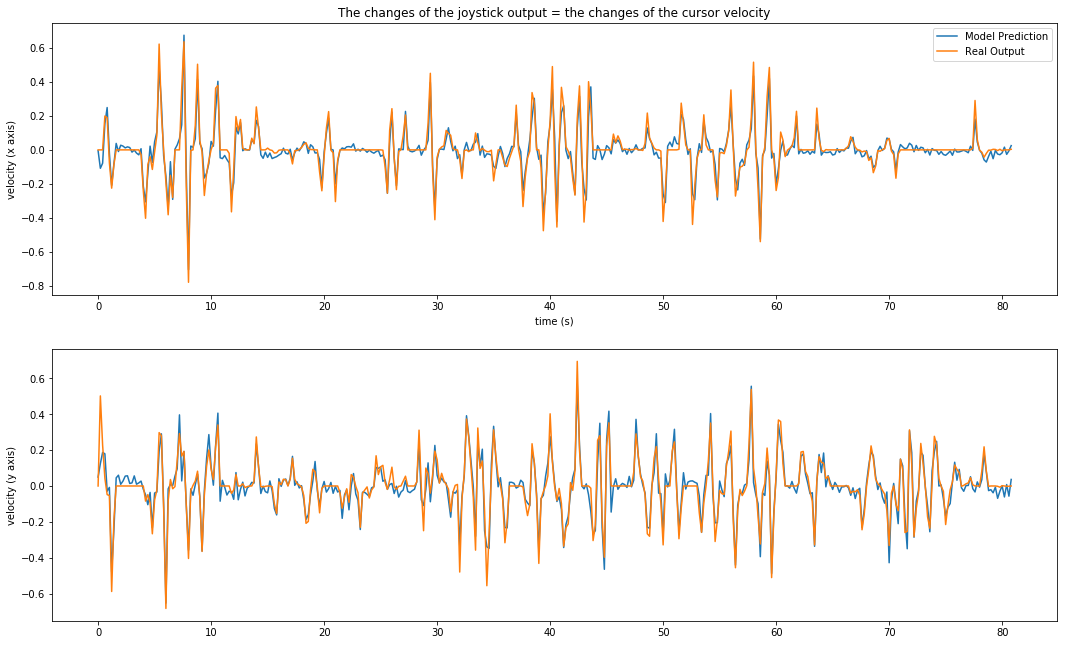

In [603]:
# Compare modelout and the actual output over time.
t2 = t/1000
fig, ax = plt.subplots(2,1, figsize=(18, 11))


#ax[0].plot(t2, poserr[:,0], 'k:', label='Positional Error (scaled)')
ax[0].plot(t2, m2out[:,0], label='Model Prediction')
ax[0].plot(t2, output[:,0], label='Real Output')
#ax[0].plot(t2, tposd[:,0], 'k:', label='Target Velocity (scaled)')

ax[0].legend()
#ax[0].plot(t2, m2errarr[:,0], 'k:')
ax[0].set_xlabel('time (s)')
ax[0].set_title('The changes of the joystick output = the changes of the cursor velocity')
ax[0].set_ylabel('velocity (x axis)')

#ax[1].plot(t2, poserr[:,1], 'k:', label='Positional Error')
ax[1].plot(t2, m2out[:,1])
ax[1].plot(t2, output[:,1])
#ax[1].plot(t2, tposd[:,1], 'k:', label='Target Velocity')

ax[1].set_ylabel('velocity (y axis)')

### Prediction error structure

Resdiual Mean: x: 6.44689409165e-17 y: 7.73627290998e-17
Resdiual StD: x: 0.0372347387939 y: 0.0323484401058


Text(0,0.5,'velocity (y axis)')

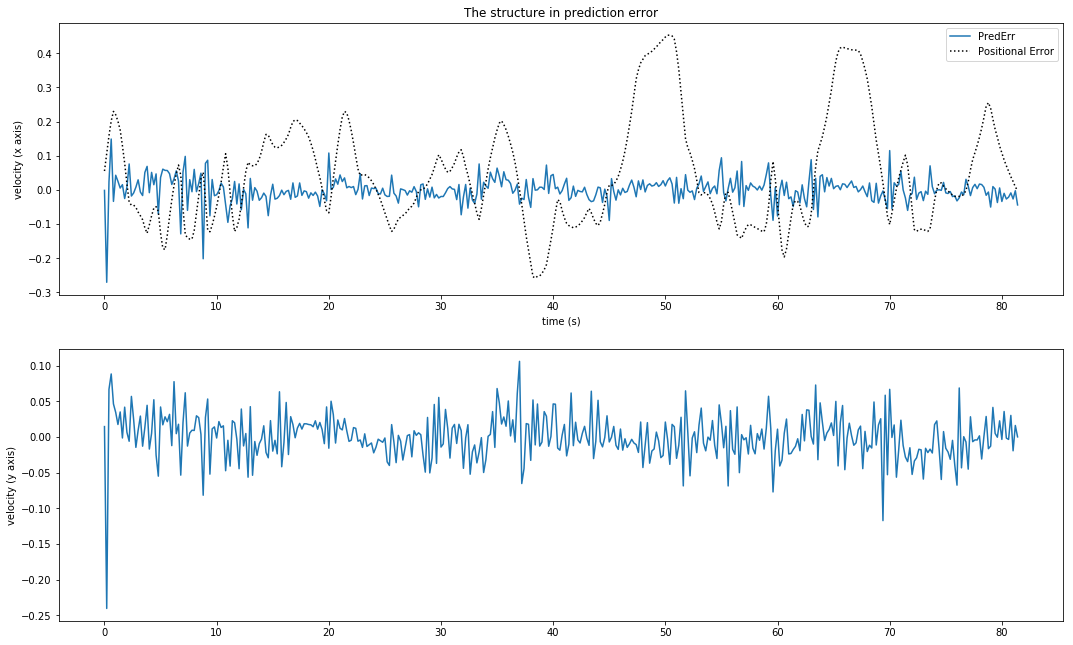

In [561]:
print('Resdiual Mean: x:',np.mean(m2errarr[:,0]),'y:',np.mean(m2errarr[:,1]))
print('Resdiual StD: x:',np.std(m2errarr[:,0]),'y:',np.std(m2errarr[:,1]))
fig, ax = plt.subplots(2,1, figsize=(18, 11))
subidx = -1
#ax[0].plot(t2[:subidx], output[:subidx,0], label='Real Output')
ax[0].plot(t2[:subidx], m2errarr[:subidx,0], label='PredErr')
#ax[0].plot(t2[:subidx], 2*nex[:subidx], label='noise')
# ax.plot(t2, m2out[:,0], label='Model Prediction')
ax[0].plot(t2[:subidx], poserr[:subidx,0], 'k:', label='Positional Error')
ax[0].legend()
#ax[0].plot(t2, m2errarr[:,0], 'k:')
ax[0].set_xlabel('time (s)')
ax[0].set_title('The structure in prediction error')
ax[0].set_ylabel('velocity (x axis)')
#ax[1].plot(t2[:subidx], output[:subidx,1], label='Real Output')
ax[1].plot(t2[:subidx], m2errarr[:subidx,1], label='PredErr')
ax[1].set_ylabel('velocity (y axis)')


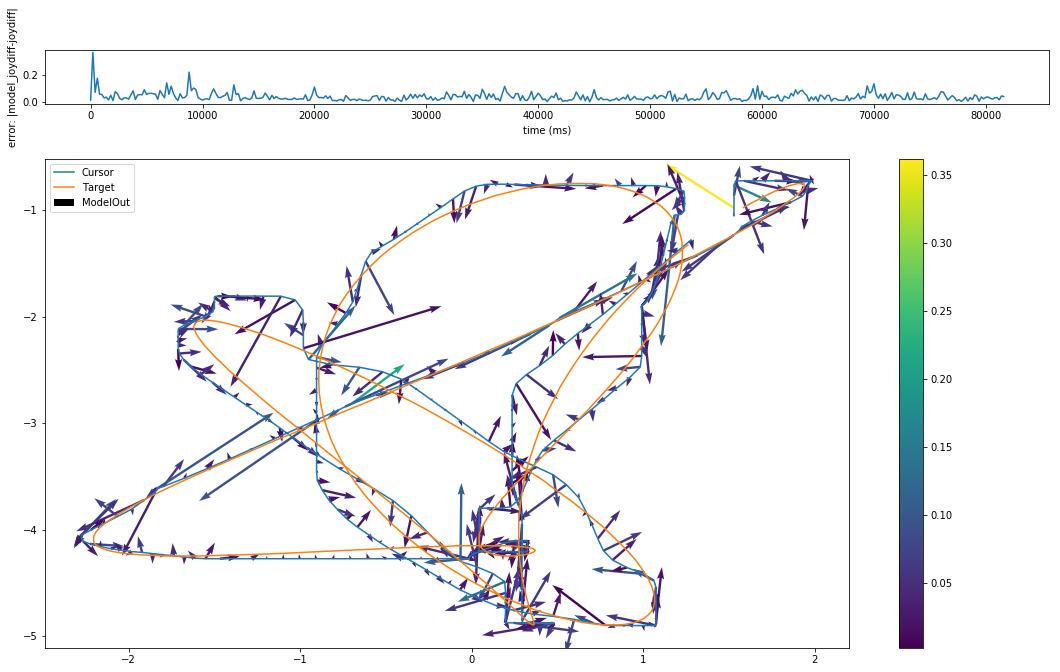

In [562]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11), gridspec_kw = {'height_ratios':[1, 9]})
ax1.plot(t, m2err)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('error: |model_joydiff-joydiff|')

# Overlay the error on the trajectory
ax2.plot(cpos[:,0], cpos[:,1], label='Cursor')
ax2.plot(tpos[:,0], tpos[:,1], label='Target')
mappable2 = ax2.quiver(cpos[:,0], cpos[:,1], m2out[:,0], m2out[:,1], m2err, label='ModelOut')
ax2.legend()
plt.colorbar(mappable2)
#plt.savefig("pred_lv2_2.png", dpi = 500)

### Model2: Plot results (Coefficients)

In [563]:
regr2.intercept_

array([-0.00244204,  0.00013376])

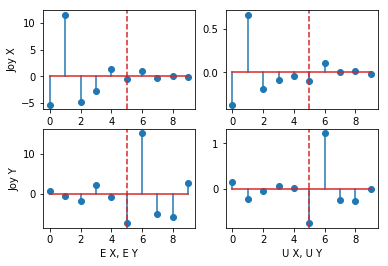

In [564]:
# Coefficients for the linear regression model
fig, ax = plt.subplots(2, 2)
ax[0,0].stem(regr2.coef_[0,0:2*winlen])
ax[0,0].set_ylabel('Joy X')
ax[0,0].axvline(x=winlen, color='#d62728', linestyle='--')

#xy=narr(np.meshgrid([-10, 10], [-40, 40])).T.reshape(4,2).T
#ax[0,0].fill(list(ax[0,0].axis())[0:2],list(ax[0,0].axis())[2:], fill=False, hatch='//')

ax[0,1].stem(regr2.coef_[0,2*winlen:])
ax[0,1].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,0].stem(regr2.coef_[1,0:2*winlen])
ax[1,0].set_xlabel('E X, E Y')#U X, U Y')
ax[1,0].set_ylabel('Joy Y')
ax[1,0].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,1].stem(regr2.coef_[1,2*winlen:])
ax[1,1].set_xlabel('U X, U Y')
ax[1,1].axvline(x=winlen, color='#d62728', linestyle='--')

plt.show()

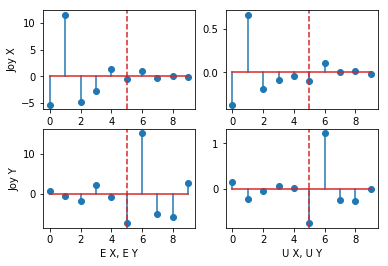

In [565]:
model_coef = np.load('Analyses/model2coef'+'.npy')
# Coefficients for the linear regression model
fig, ax = plt.subplots(2, 2)
ax[0,0].stem(model_coef[0,0:2*winlen])
ax[0,0].set_ylabel('Joy X')
ax[0,0].axvline(x=winlen, color='#d62728', linestyle='--')

#xy=narr(np.meshgrid([-10, 10], [-40, 40])).T.reshape(4,2).T
#ax[0,0].fill(list(ax[0,0].axis())[0:2],list(ax[0,0].axis())[2:], fill=False, hatch='//')

ax[0,1].stem(model_coef[0,2*winlen:])
ax[0,1].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,0].stem(model_coef[1,0:2*winlen])
ax[1,0].set_xlabel('E X, E Y')#U X, U Y')
ax[1,0].set_ylabel('Joy Y')
ax[1,0].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,1].stem(model_coef[1,2*winlen:])
ax[1,1].set_xlabel('U X, U Y')
ax[1,1].axvline(x=winlen, color='#d62728', linestyle='--')

In [566]:
# Check if output*MAP = cursor position
#tnextcpos = (mean(cpos)+scale_f*cpos[100,:])+5*outputI[100,:]+exsig[100,:]
#print(tnextcpos)

In [567]:
# # Predict 1-step
# ex = vec2window(poserr[:,0], winlen)
# ey = vec2window(poserr[:,1], winlen)

# tempvar = np.pad(outputI, ((1,0),(0, 0)), 'constant')[:-1] # To avoid using the current value of output!
# ux = vec2window(tempvar[:, 0], winlen)
# uy = vec2window(tempvar[:, 1], winlen)

# features = np.hstack((ex, ey, ux, uy))

# regr2 = linear_model.LinearRegression()
# regr2.fit(features, output)
# m2out = regr2.predict(features)
# print("Score: ", regr2.score(features, output))
# m2errarr = m2out-output
# m2err = np.linalg.norm(m2out-output, axis=1)

# Include the prediction into the feature vector
#unew = output+outputI
#enew = tnew - pos(unew)
#pos(unew) = MAP*unew + perturb










## Model 2.1 - Exclude deadbands

In [568]:
thresh_ox = 0.15 #0.17 # Work on identifying the threshold more accurately
thresh_oy = 0.15 #0.25
w_sox = abs(output[:,0])>thresh_ox
w_soy = abs(output[:,1])>thresh_oy# weight of sample - output - y direction
w_so = np.logical_or(w_sox, w_soy)
print(np.sum(w_so))

73


In [569]:
regr21 = linear_model.LinearRegression(fit_intercept=False)
regr21.fit(features, output, sample_weight=w_so)
m21out = regr21.predict(features[w_so])
print("Score: ", regr21.score(features[w_so], output[w_so]))
m21errarr = m21out-output[w_so]
m21err = np.linalg.norm(m21out-output[w_so], axis=1)

Score:  0.950668009115


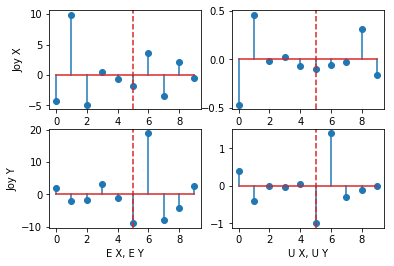

In [570]:
# Coefficients for the linear regression model
fig, ax = plt.subplots(2, 2)
ax[0,0].stem(regr21.coef_[0,0:2*winlen])
ax[0,0].set_ylabel('Joy X')
ax[0,0].axvline(x=winlen, color='#d62728', linestyle='--')

#xy=narr(np.meshgrid([-10, 10], [-40, 40])).T.reshape(4,2).T
#ax[0,0].fill(list(ax[0,0].axis())[0:2],list(ax[0,0].axis())[2:], fill=False, hatch='//')

ax[0,1].stem(regr21.coef_[0,2*winlen:])
ax[0,1].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,0].stem(regr21.coef_[1,0:2*winlen])
ax[1,0].set_xlabel('E X, E Y')#U X, U Y')
ax[1,0].set_ylabel('Joy Y')
ax[1,0].axvline(x=winlen, color='#d62728', linestyle='--')

ax[1,1].stem(regr21.coef_[1,2*winlen:])
ax[1,1].set_xlabel('U X, U Y')
ax[1,1].axvline(x=winlen, color='#d62728', linestyle='--')

plt.show()

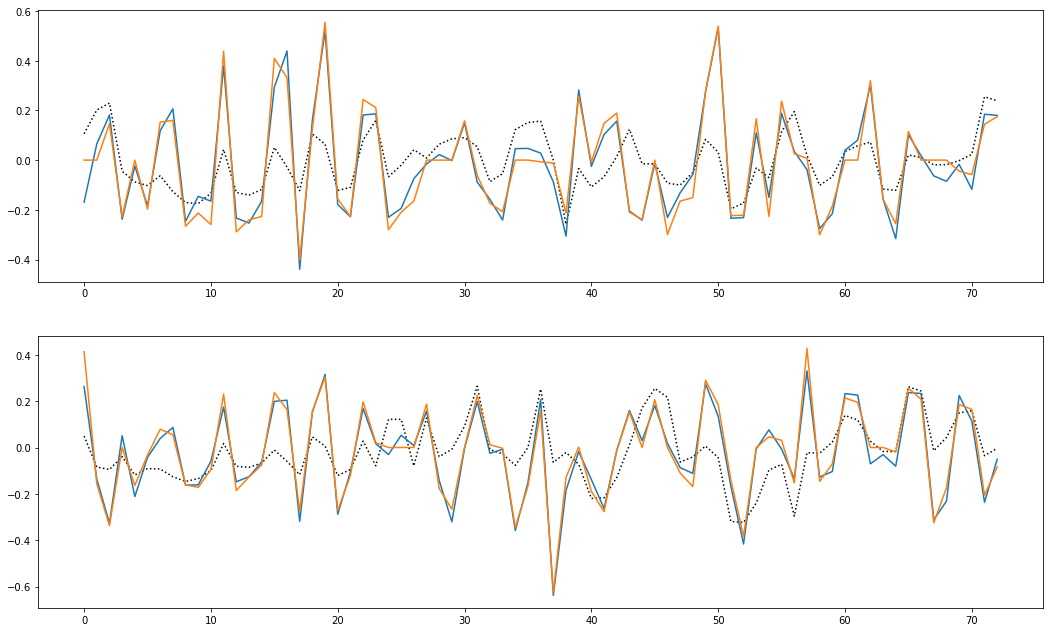

In [571]:
fig, ax = plt.subplots(2,1, figsize=(18, 11))


ax[0].plot(poserr[w_so,0], 'k:', label='Positional Error (scaled)')
ax[0].plot(m21out[:,0], label='Model Prediction')
ax[0].plot(output[w_so,0], label='Real Output')

ax[1].plot(poserr[w_so,1], 'k:', label='Positional Error')
ax[1].plot(m21out[:,1])
ax[1].plot(output[w_so,1])

Score:  0.523494801169


Text(0,0.5,'velocity (y axis)')

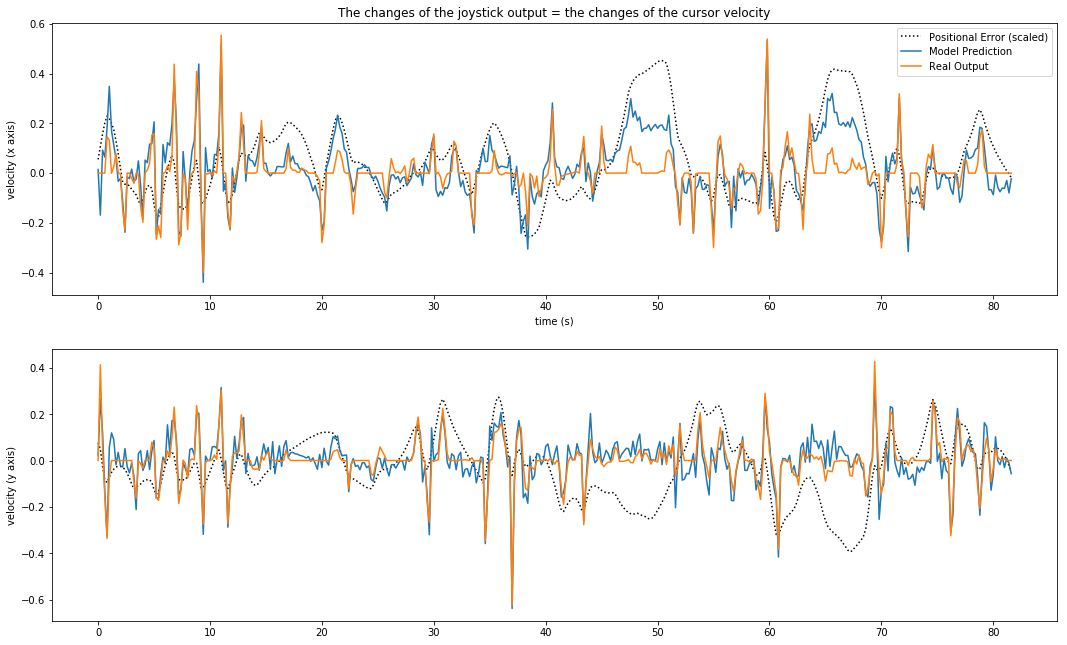

In [572]:
m21out = regr21.predict(features)
print("Score: ", regr21.score(features, output))
m21errarr = m21out-output
m21err = np.linalg.norm(m21out-output, axis=1)

# Compare modelout and the actual output over time.
t2 = t/1000
fig, ax = plt.subplots(2,1, figsize=(18, 11))


ax[0].plot(t2, poserr[:,0], 'k:', label='Positional Error (scaled)')
ax[0].plot(t2, m21out[:,0], label='Model Prediction')
ax[0].plot(t2, output[:,0], label='Real Output')
#ax[0].plot(t2, tposd[:,0], 'k:', label='Target Velocity (scaled)')

ax[0].legend()
#ax[0].plot(t2, m2errarr[:,0], 'k:')
ax[0].set_xlabel('time (s)')
ax[0].set_title('The changes of the joystick output = the changes of the cursor velocity')
ax[0].set_ylabel('velocity (x axis)')

ax[1].plot(t2, poserr[:,1], 'k:', label='Positional Error')
ax[1].plot(t2, m21out[:,1])
ax[1].plot(t2, output[:,1])
#ax[1].plot(t2, tposd[:,1], 'k:', label='Target Velocity')

ax[1].set_ylabel('velocity (y axis)')

#### Conclusion
It seems like the data inside deadband is important since the model is interpolating in a wrong way. We need to train the deadband length.

## Model 2.2

In [573]:
from scipy.optimize import minimize

thresh = 0.075

abse = np.sqrt(np.square(ex)+np.square(ey))
abse2 = np.sqrt(np.square(ex[:,0:3])+np.square(ey[:,0:3]))
exd = narr([ex[:,0]-ex[:,1]]).T
eyd = narr([ey[:,0]-ey[:,1]]).T
absed2 = np.sqrt(np.square(exd)+np.square(eyd))

def model22(thresh):
    feature_mask = abse>thresh
    feature_mask = np.concatenate((feature_mask, feature_mask, 
                                   np.ones((feature_mask.shape[0],2*feature_mask.shape[1]))), axis=1)
    features2 = feature_mask*features
    regr22 = linear_model.LinearRegression()
    regr22.fit(features2, output)
    return -regr22.score(features2, output) # Minimize the negative of score

def model23(thresh):
    feature_mask = abse2>thresh[0]
    feature_mask2 = absed2>thresh[1]
    
    feature_mask = np.concatenate((feature_mask, feature_mask, feature_mask2, feature_mask2), axis=1)
    
    features2 = np.concatenate((ex[:,0:3], ey[:,0:3], exd, eyd),axis=1)
    features2 = feature_mask*features2
    #features2 = np.concatenate((features2, ex[:,0:3], ey[:,0:3]),axis=1)
    regr22 = linear_model.LinearRegression()
    regr22.fit(features2, output)
    return -regr22.score(features2, output) # Minimize the negative of score

In [574]:
from scipy.optimize import differential_evolution

In [575]:
#x0 = [0.015, 0.015]
#x0 = [0.015]
#bnd=[(0,0.99)]
bnd=[(0,0.99),(0,0.99)]
#result22 = minimize(model22, x0, method='Nelder-Mead', options={'disp':True, 'maxiter':100})
result23 = differential_evolution(model23, bounds=bnd, tol=1e-6)

In [576]:
print(result23)
#minimize.show_options('minimize', 'Nelder-Mead')

     fun: -0.78789801108076263
 message: 'Optimization terminated successfully.'
    nfev: 843
     nit: 27
 success: True
       x: array([ 0.00633825,  0.05874132])


## Model 2.x

In [577]:
#MLP

regr2x = MLPRegressor(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.005)

regr2x.fit(features, output[:,0])
m2xout = regr2x.predict(features)
print("Score: ", regr2x.score(features, output[:,0]))

Score:  0.449873383773


## Model 3
features: Model2 features + Target Position (Useful for perturbation)

In [578]:
# features: (1) x = [t, e, u] for the past 15 frames
#winlen = 15
tx = vec2window(tpos[:, 0], winlen)
ty = vec2window(tpos[:, 1], winlen)

ex = vec2window(poserr[:,0], winlen)
ey = vec2window(poserr[:,1], winlen)

tempvar = np.pad(output, ((1,0),(0, 0)), 'constant')[:-1]
ux = vec2window(tempvar[:, 0], winlen)
uy = vec2window(tempvar[:, 1], winlen)

features = np.hstack((tx, ty, ex, ey, ux, uy))

In [579]:
regr3 = linear_model.LinearRegression()
regr3.fit(features, output)
m3out = regr3.predict(features)
print("Score: ", regr3.score(features, output))
m3err = np.linalg.norm(m3out-output, axis=1)

Score:  0.941896816487


### Save the Model

In [580]:
np.save('Analyses/model3coef',regr3.coef_)
description = 'coefs=[\n tx2x, ty2x, ex2x,ey2x,ux2x,uy2x \n tx2y, ty2y, ex2y,ey2y,ux2y,uy2y]' +\
            '\n window length='+str(winlen) +\
            '\n sampling period='+str(sp) +\
            '\n scaling weight='+str(scale_f) +\
            '\n scaling bias='+str(scale_b)

with open('Analyses/model3desc', "w")as textfile:
    textfile.write(description)

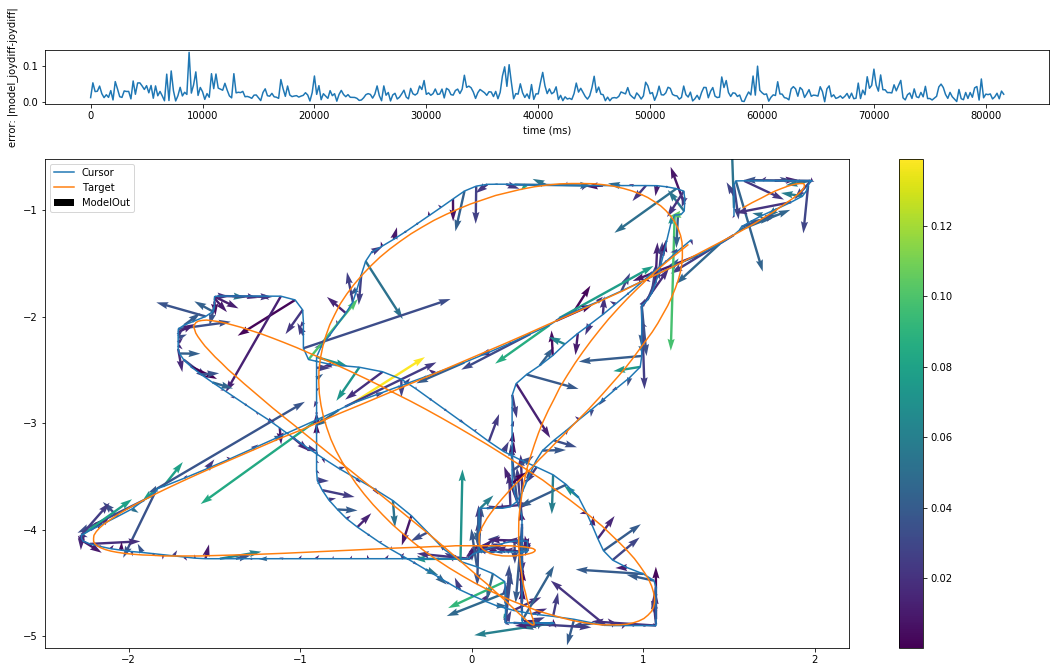

In [581]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11), gridspec_kw = {'height_ratios':[1, 9]})
ax1.plot(t, m3err)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('error: |model_joydiff-joydiff|')

# Overlay the error on the trajectory
ax2.plot(cpos[:,0], cpos[:,1], label='Cursor')
ax2.plot(tpos[:,0], tpos[:,1], label='Target')
mappable2 = ax2.quiver(cpos[:,0], cpos[:,1], m3out[:,0], m3out[:,1], m3err, label='ModelOut')
ax2.legend()
plt.colorbar(mappable2)
#plt.savefig("pred_lv2_2.png", dpi = 500)

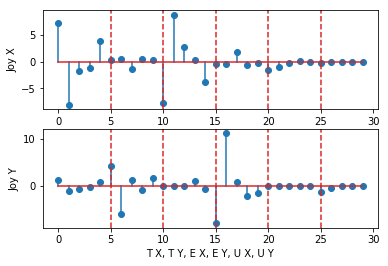

In [582]:
# Coefficients for the linear regression model
fig, ax = plt.subplots(2, 1)
ax[0].stem(regr3.coef_[0,:])
ax[0].set_ylabel('Joy X')
ax[0].axvline(x=winlen, color='#d62728', linestyle='--')
ax[0].axvline(x=winlen*2, color='#d62728', linestyle='--')
ax[0].axvline(x=winlen*3, color='#d62728', linestyle='--')
ax[0].axvline(x=winlen*4, color='#d62728', linestyle='--')
ax[0].axvline(x=winlen*5, color='#d62728', linestyle='--')

ax[1].stem(regr3.coef_[1,:])
ax[1].set_xlabel('T X, T Y, E X, E Y, U X, U Y')
ax[1].set_ylabel('Joy Y')
ax[1].axvline(x=winlen, color='#d62728', linestyle='--')
ax[1].axvline(x=winlen*2, color='#d62728', linestyle='--')
ax[1].axvline(x=winlen*3, color='#d62728', linestyle='--')
ax[1].axvline(x=winlen*4, color='#d62728', linestyle='--')
ax[1].axvline(x=winlen*5, color='#d62728', linestyle='--')

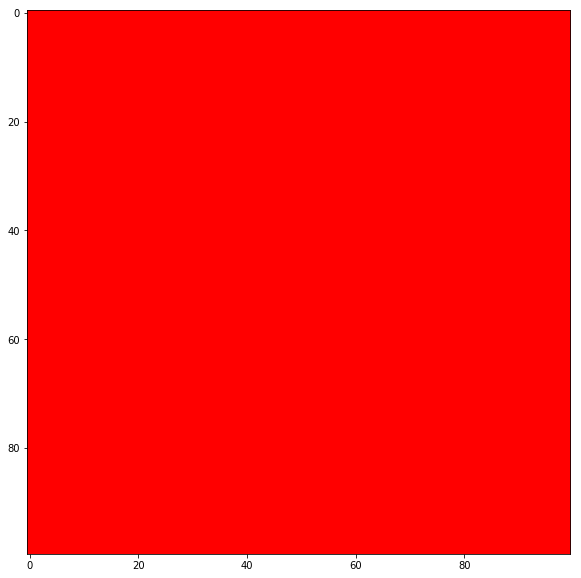

In [583]:
# Just to clearly separate what comes next.
plt.subplots(1,1, figsize=(10,10))
plt.imshow(np.ones((100,100,1))+np.array([0,255,255]))

# Test the Models

In [584]:
result_dr = '/home/saber/hhgame/saved_data/single-pt4/18-11-16-11-53'
level=2

test_batch_s = Fs*1
test_batch_e = -Fs*1

In [585]:
resdf = pd.read_csv(result_dr+'/results_lv'+str(level)+'.csv', quoting=3, escapechar=' ')
newrep_i = resdf.Timestamp[resdf.Timestamp==0].index.values
resdf1 = resdf[:newrep_i[0]]
resdf2 = resdf[newrep_i[0]+1:-1]

TestData = resdf2[test_batch_s:test_batch_e]
t, tpos, tposd, cpos, exsig, poserr, output, outputI = preproc(TestData, scale_f, scale_b, sp)

# Converting the data from the game coordinates to analysis coordinates.
# TestData = TestData.set_index('Timestamp')
# ind_temp = pd.to_datetime(TestData.index, unit='ms')
# TestData.index = ind_temp
# # TestData = TestData.asfreq('1ms')
# # TestData=TestData.resample('200ms').mean()
# #t = TestData.Timestamp.values - min(TestData.Timestamp.values)
# t = pd.to_numeric(TestData.index)/1000000
# t = t-min(t)

# tpos = narr([TestData.KernelEndX.values, TestData.KernelEndY.values], dtype=float).T
# scale_f = tpos.std()
# tpos[:, 0] = (tpos[:, 0]-np.mean(tpos[:, 0]))/scale_f 
# tpos[:, 1] = (tpos[:, 1]-np.mean(tpos[:, 1]))/scale_f # Center around 0, but scale by the same factor

# cpos = narr([TestData.CursorPosX.values, TestData.CursorPosY.values], dtype=float).T
# cpos[:, 0] = (cpos[:, 0]-np.mean(cpos[:, 0]))/scale_f 
# cpos[:, 1] = (cpos[:, 1]-np.mean(cpos[:, 1]))/scale_f

# poserr = tpos - cpos

# output = narr([TestData.Joy1PosX.values, TestData.Joy1PosY.values]).T

In [586]:
# Trim other variables too
# output = output[winlen:, :]
# t = t[winlen:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4695169710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4693b10d30>]], dtype=object)

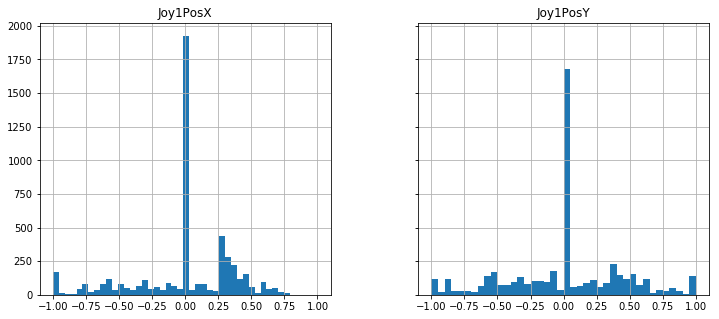

In [587]:
resdf.hist(column=['Joy1PosX','Joy1PosY'], bins=40, sharex=True, sharey=True, figsize=(12, 5))

## Model 2: Test

In [588]:
# 2nd model
# features: (1) x = [e, u] for the past 15 frames
ex = vec2window(poserr[:,0], winlen)
ey = vec2window(poserr[:,1], winlen)

# nex = poserr[:,0]*np.random.rand(poserr.shape[0])
# ney = poserr[:,1]*np.random.rand(poserr.shape[0])

tempvar = np.pad(outputI, ((1,0),(0, 0)), 'constant')[:-1] # To avoid using the current value of output!
ux = vec2window(tempvar[:, 0], winlen)
uy = vec2window(tempvar[:, 1], winlen)

#features = np.hstack((ex, ey, ux, uy, nex[..., np.newaxis], ney[..., np.newaxis])) #@@@@@@@@@@@@@@@@@@@@@@

features = np.hstack((ex, ey, ux, uy))
m2out = regr2.predict(features)
print("Score: ", regr2.score(features, output))
m2errarr = m2out-output
m2err = np.linalg.norm(m2out-output, axis=1)

Score:  0.897250568907


Text(0,0.5,'velocity (y axis)')

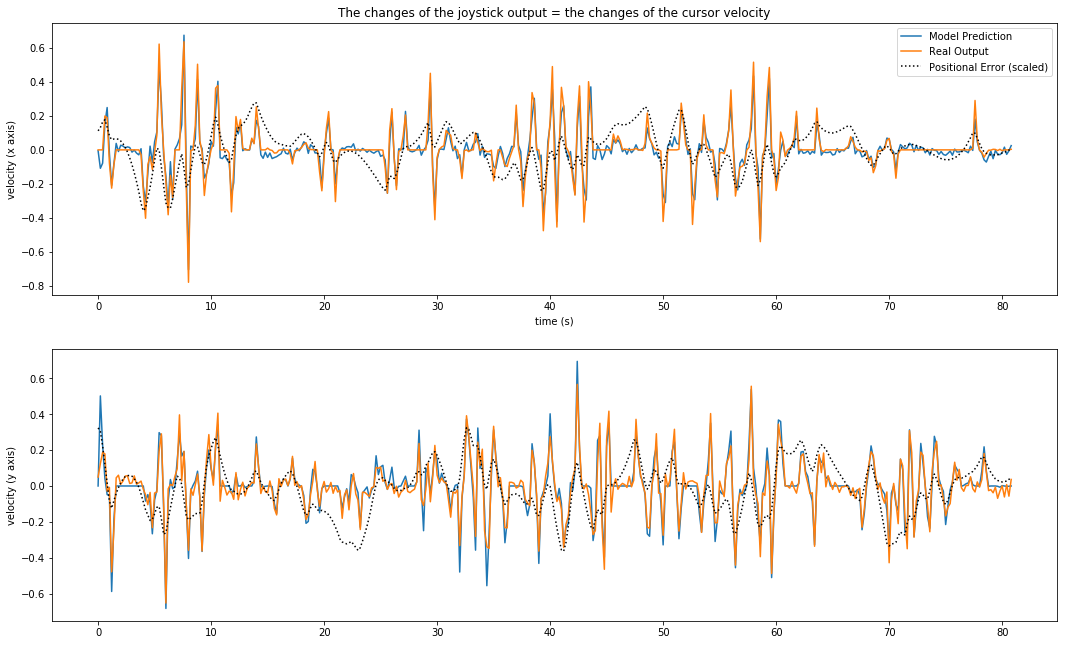

In [589]:
# Compare modelout and the actual output over time.
t2 = t/1000
fig, ax = plt.subplots(2,1, figsize=(18, 11))

ax[0].plot(t2, m2out[:,0], label='Model Prediction')
ax[0].plot(t2, output[:,0], label='Real Output')

#ax[0].plot(t2, tposd[:,0], 'k:', label='Target Velocity (scaled)')
ax[0].plot(t2, poserr[:,0], 'k:', label='Positional Error (scaled)')
ax[0].legend()
#ax[0].plot(t2, m2errarr[:,0], 'k:')
ax[0].set_xlabel('time (s)')
ax[0].set_title('The changes of the joystick output = the changes of the cursor velocity')
ax[0].set_ylabel('velocity (x axis)')
ax[1].plot(t2, output[:,1])
ax[1].plot(t2, m2out[:,1])
#ax[1].plot(t2, tposd[:,1], 'k:', label='Target Velocity')
ax[1].plot(t2, poserr[:,1], 'k:', label='Positional Error')
ax[1].set_ylabel('velocity (y axis)')

Resdiual Mean: x: -0.00296761551357 y: -0.00266528570822
Resdiual StD: x: 0.0473389529253 y: 0.0506322280825


Text(0,0.5,'velocity (y axis)')

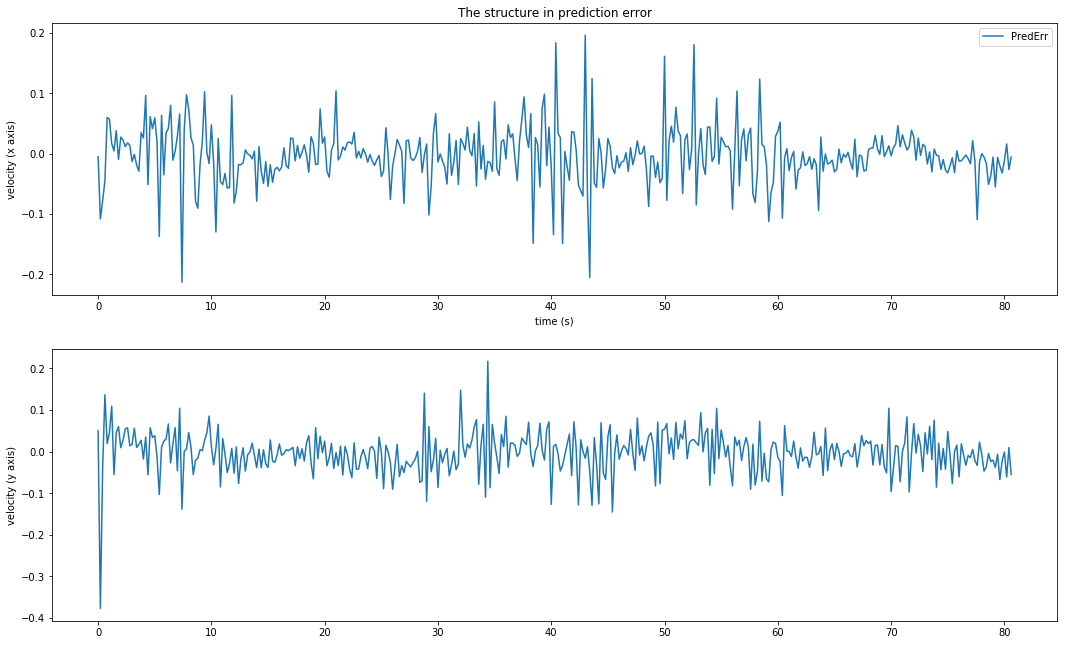

In [590]:
print('Resdiual Mean: x:',np.mean(m2errarr[:,0]),'y:',np.mean(m2errarr[:,1]))
print('Resdiual StD: x:',np.std(m2errarr[:,0]),'y:',np.std(m2errarr[:,1]))
fig, ax = plt.subplots(2,1, figsize=(18, 11))
subidx = -1
#ax[0].plot(t2[:subidx], output[:subidx,0], label='Real Output')
ax[0].plot(t2[:subidx], m2errarr[:subidx,0], label='PredErr')
#ax[0].plot(t2[:subidx], 2*nex[:subidx], label='noise')
# ax.plot(t2, m2out[:,0], label='Model Prediction')
#ax[0].plot(t2[:subidx], poserr[:subidx,0], 'k:', label='Positional Error')
ax[0].legend()
#ax[0].plot(t2, m2errarr[:,0], 'k:')
ax[0].set_xlabel('time (s)')
ax[0].set_title('The structure in prediction error')
ax[0].set_ylabel('velocity (x axis)')
#ax[1].plot(t2[:subidx], output[:subidx,1], label='Real Output')
ax[1].plot(t2[:subidx], m2errarr[:subidx,1], label='PredErr')
ax[1].set_ylabel('velocity (y axis)')

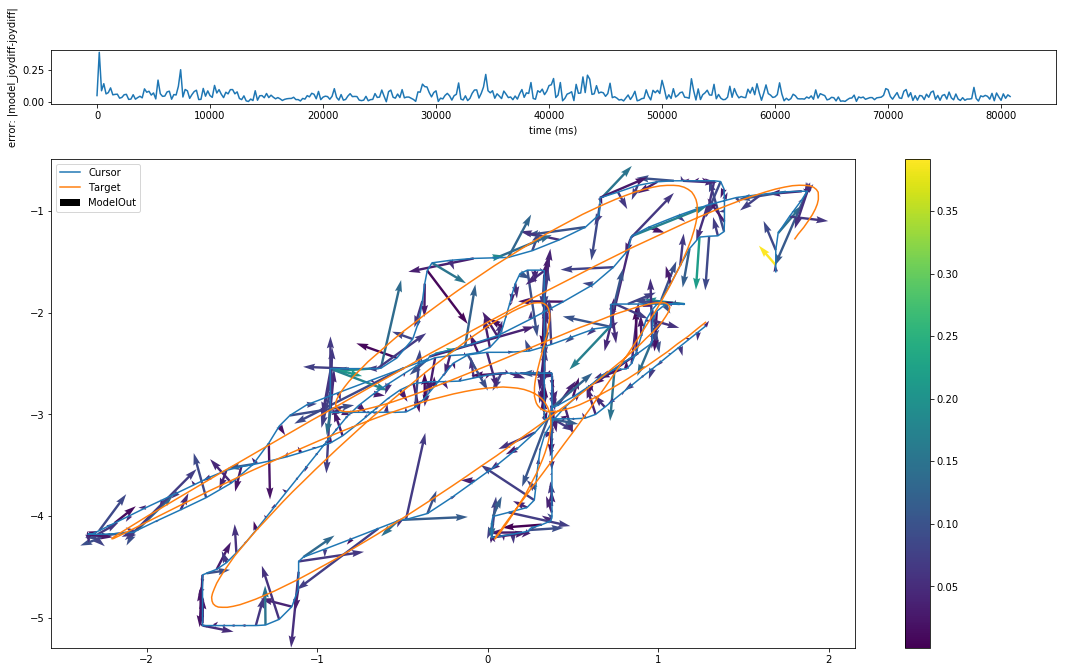

In [591]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11), gridspec_kw = {'height_ratios':[1, 9]})
ax1.plot(t, m2err)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('error: |model_joydiff-joydiff|')

# Overlay the error on the trajectory
ax2.plot(cpos[:,0], cpos[:,1], label='Cursor')
ax2.plot(tpos[:,0], tpos[:,1], label='Target')
mappable2 = ax2.quiver(cpos[:,0], cpos[:,1], m2out[:,0], m2out[:,1], m2err, label='ModelOut')
ax2.legend()
plt.colorbar(mappable2)
plt.savefig("model2.png", dpi = 400)

## Model 2.1

In [592]:
w_sox = abs(output[:,0])>thresh_ox
w_soy = abs(output[:,1])>thresh_oy# weight of sample - output - y direction
w_so = np.logical_or(w_sox, w_soy)
print(np.sum(w_so))

m21out = regr21.predict(features[w_so])
print("Score: ", regr21.score(features[w_so], output[w_so]))
#m21out = regr21.predict(features)
#print("Score: ", regr21.score(features, output))

#m21err = np.linalg.norm(m21out-output, axis=1)

152
Score:  0.873915893458


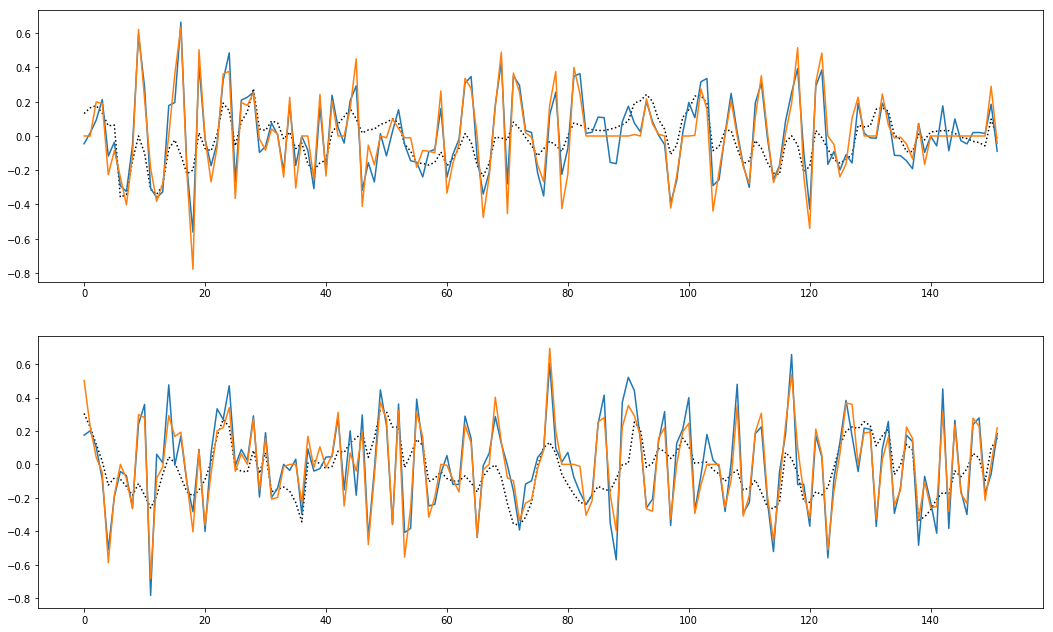

In [593]:
fig, ax = plt.subplots(2,1, figsize=(18, 11))


ax[0].plot(poserr[w_so,0], 'k:', label='Positional Error (scaled)')
ax[0].plot(m21out[:,0], label='Model Prediction')
ax[0].plot(output[w_so,0], label='Real Output')

ax[1].plot(poserr[w_so,1], 'k:', label='Positional Error')
ax[1].plot(m21out[:,1])
ax[1].plot(output[w_so,1])

## K-step ahead test

In [594]:
test_model = regr2 # Select the tested model

In [595]:
class KStepAheadPredictor():

    def __init__(self, data2regr, regressor, regr2sim, simulator):
        self.regrprep = data2regr
        self.regr = regressor
        self.simprep = regr2sim
        self.sim = simulator
        #raise NotImplementedError
    
    def predict(data_features, k):
        # data_features is an array of shape nsamples x(20*2)
        # Create kouts = np.zeros([n_samples, k])
        # Go through the data, sample by sample.
            # First prediction:
                # Apply data2regr on features
                # Apply regressor to predict output
                # Store the prediction in kouts[sample_num, k_num]
            
            # for ki in range(1,k)           
                # prepare prediction to feed to simulator. regr2sim(predictions).
                # Build the new feature using the simulator. error = sim(output)
                # Append the new feature to the feature window. list.insert(); del list[-1];
                # Apply preproc on features
                # Apply regressor to predict output
                # Store the prediction in kouts[sample_num, k_num]
                
        raise NotImplementedError
        
    def evaluate(self, data_output):
        # Compare the k-step predictions with the real data
        raise NotImplementedError

    
def regr2sim(du, u, scale_f, dsr=1):
    # dsr: downsampling rate, i.e. sr_old/sr_new
    out = u+du #Add du with u.
    movement = out*dsr; # Account for resampling. (dx = v*dt => sr = dt_new/dt_old)
    movement_s = movement/scale_f # Convert it to analysis coordinates, 
        #cause the model predicts movement in game coordinates, but 
        # the simulator currently works in analysis coordinates for simplicity.
    return movement_s

def simulator(joy, target, cursor, ind=0):
    
    #tpos = narr([Data.KernelEndX.values, Data.KernelEndY.values], dtype=float).T
    
    # Move the cursor
    MAP1 = narr([5.,5.])
    cursor_new = cursor + joy*MAP1 #+perturbation.flatten()
    # Move the target: roll the target traj backwards by <ind> positions, to get future target positions
    target_new = np.roll(target, -ind)
    
    return cursor_new, target_new - cursor_new

In [596]:
n_samples = len(t)
k = 50
kouts = np.zeros((n_samples, 2, k))
kstepr2 = np.zeros((k))

# Create initial feature components
ex = vec2window(poserr[:,0], winlen)
ey = vec2window(poserr[:,1], winlen)
tempvar = np.pad(outputI, ((1,0),(0, 0)), 'constant')[:-1] # To avoid using the current value of output!
ux = vec2window(tempvar[:, 0], winlen)
uy = vec2window(tempvar[:, 1], winlen)
newcpos = cpos
    
for ki in range(k):
    features = np.hstack((ex, ey, ux, uy))
    modelout = test_model.predict(features)
    kouts[:,:, ki] = modelout # Save output
    kstepr2[ki] = r2_score(np.roll(output, -ki), modelout, sample_weight=None, multioutput='variance_weighted')
    previous_out = narr([features[:, 2*winlen],features[:, 3*winlen]]).T # Pick most recent ux, uy
    newjoy = regr2sim(modelout, previous_out, scale_f=scale_f, dsr=dsr)
    newcpos, newerr = simulator(newjoy, target=tpos, cursor=newcpos, ind=ki)
    # Append newjoy, newerr to ex, ey,ux,uy
    # solution1
    ex = np.concatenate((newerr[:,0, np.newaxis],ex[:,0:-1]), axis=1)
    # solution2
#     ex= np.roll(ex, 1, axis=)
#     ex[:,0] = newerr[:,0]
    ey = np.concatenate((newerr[:,1, np.newaxis], ey[:,0:-1]), axis=1)
    ux = np.concatenate((newjoy[:,0, np.newaxis], ux[:,0:-1]), axis=1)
    uy = np.concatenate((newjoy[:,1, np.newaxis], uy[:,0:-1]), axis=1)
                         

[  8.97250569e-01  -1.29543494e+01  -1.47082839e+04  -9.99927216e+03
  -6.98329365e+03  -5.13532327e+04  -1.95275194e+04  -7.62786111e+04
  -3.14593352e+05  -8.87074134e+04  -5.17624487e+05  -2.16899199e+06
  -7.04039470e+05  -2.95257600e+06  -1.46836722e+07  -6.13666635e+06
  -1.52291099e+07  -9.56773542e+07  -5.14591632e+07  -7.20407949e+07
  -6.00997252e+08  -4.10260019e+08  -3.10747479e+08  -3.65714874e+09
  -3.12861731e+09  -1.19298502e+09  -2.16355089e+10  -2.29770021e+10
  -3.89336623e+09  -1.24699461e+11  -1.63391648e+11  -1.02372808e+10
  -7.00707204e+11  -1.12955637e+12  -2.94312585e+10  -3.83677254e+12
  -7.61429421e+12  -2.94298595e+11  -2.04373601e+13  -5.01600093e+13
  -4.40149146e+12  -1.05590734e+14  -3.23441535e+14  -5.36468156e+13
  -5.26713176e+14  -2.04380634e+15  -5.49714120e+14  -2.51929050e+15
  -1.26651447e+16  -5.00946430e+15]


<Container object of 3 artists>

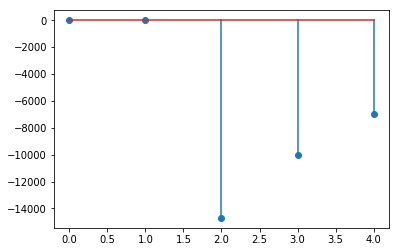

In [597]:
print(kstepr2)
plt.stem(kstepr2[:5])

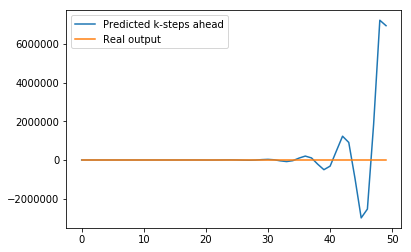

In [598]:
# Plot the predicted 10 steps ahead and compare it to the real data.
sample_num = 100
_,ax = plt.subplots(1,1)
ax.plot(kouts[sample_num, 0,:], label='Predicted k-steps ahead')
ax.plot(output[sample_num:sample_num+k,0], label='Real output')
ax.legend()
#plt.plot(output[:,0])

## Model 2.x: Test

In [599]:
print("Score: ", regr2x.score(features, output[:,0]))

Score:  -3.117599806e+12


## Model 3: Test

In [600]:
# 2nd model
# features: (1) x = [e, u] for the past 15 frames
#winlen = 15
tx = vec2window(tpos[:, 0], winlen)
ty = vec2window(tpos[:, 1], winlen)

ex = vec2window(poserr[:,0], winlen)
ey = vec2window(poserr[:,1], winlen)

tempvar = np.pad(output, ((1,0),(0, 0)), 'constant')[:-1]
ux = vec2window(tempvar[:, 0], winlen)
uy = vec2window(tempvar[:, 1], winlen)

features = np.hstack((tx, ty, ex, ey, ux, uy))
m3out = regr3.predict(features)
print("Score: ", regr3.score(features, output))
m3err = np.linalg.norm(m3out-output, axis=1)

Score:  0.943129041945


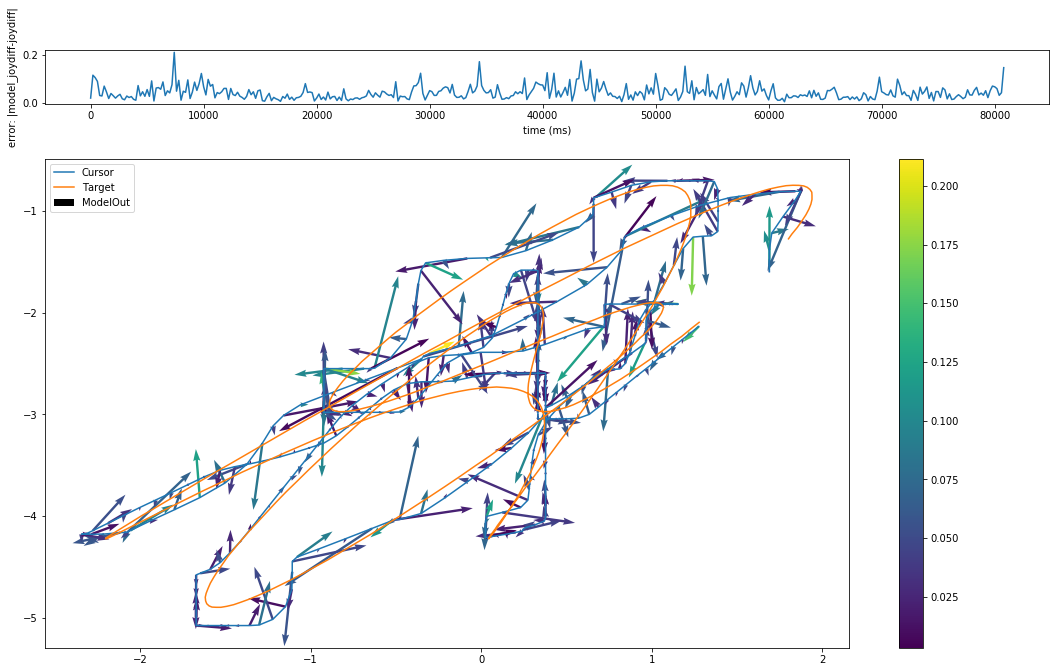

In [601]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11), gridspec_kw = {'height_ratios':[1, 9]})
ax1.plot(t, m3err)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('error: |model_joydiff-joydiff|')

# Overlay the error on the trajectory
ax2.plot(cpos[:,0], cpos[:,1], label='Cursor')
ax2.plot(tpos[:,0], tpos[:,1], label='Target')
mappable2 = ax2.quiver(cpos[:,0], cpos[:,1], m3out[:,0], m3out[:,1], m3err, label='ModelOut')
ax2.legend()
plt.colorbar(mappable2)
#plt.savefig("pred_lv2_2.png", dpi = 500)

### Harder tests for model2

In [602]:
# SVD
# See how the reconstructed version performs.